# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.
This tutorial explains the main features in walk-through examples. It covers:

1. Basic usage
2. Plotting
3. Nonlinear conditional independence tests
4. Symbolic time series

PCMCI is described here:
J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, 
Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) 
https://advances.sciencemag.org/content/5/11/eaau4996

For further versions of PCMCI (e.g., PCMCI+, LPCMCI, etc.), see the corresponding tutorials.

See the following paper for theoretical background:
Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

## 1. Basic usage

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

Consider time series coming from a data generating process

\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^3_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + 0.5 X^1_{t-2} + 0.6 X^3_{t-3} + \eta^2_t\\
X^3_t &= 0.7 X^3_{t-1} + \eta^3_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable. In Tigramite such a process can be generated with the function ``pp.var_process``.

In [2]:
np.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)


First, we plot the time series. This can be done with the function ``tp.plot_timeseries``

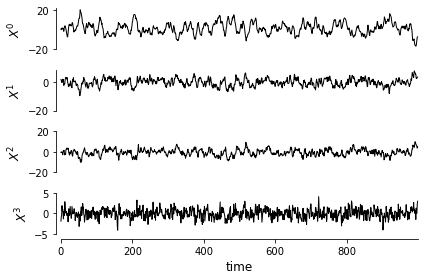

In [3]:
tp.plot_timeseries(dataframe); plt.show()

It's stationary and doesn't contain missing values (covered in other tutorial). Next, we choose a conditional independence test, here we start with ``ParCorr`` implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. Then we initialize the ``PCMCI`` method with  ``dataframe``, and ``cond_ind_test``:

In [4]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

Before running the causal algorithm, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations. This can help to identify which maximal time lag ``tau_max`` to choose in the causal algorithm.


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


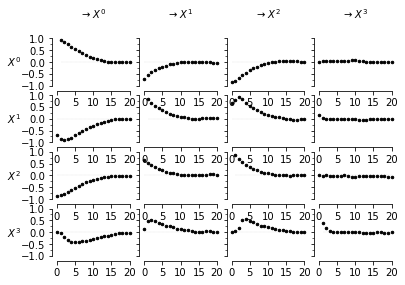

In [5]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

Since the dependencies decay beyond a maximum lag of around 8, we choose ``tau_max=8`` for PCMCI. The other main parameter is ``pc_alpha`` which sets the significance level in the condition-selection step. Here we let PCMCI choose the optimal value by setting it to ``pc_alpha=None``. Then PCMCI will optimize this parameter in the ParCorr case by the Akaike Information criterion among a reasonable default list of values (e.g., ``pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]``). The parameter ``alpha_level=0.01`` indicates that we threshold the resulting p-value matrix at this significance level to obtain the graph. 

In [6]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None, alpha_level=0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 7 link(s):
    [pc_alpha = 0.3]
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.796
        ($X^1$ -1): max_pval = 0.00000, min_val = -0.748
        ($X^3$ -2): max_pval = 0.13715, min_val =  0.048
        ($X^3$ -1): max_pval = 0.19326, min_val = -0.042
        ($X^2$ -1): max_pval = 0.20477, min_val = -0.041
        ($X^3$ -7): max_pval = 0.25822, min_val =  0.036
        ($X^1$ -4): max_pval = 0.26548, min_val =  0.036

    Variable $X^1$ has 4 link(s):
    [pc_alpha = 0.3]
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.695
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.484
        ($X^3$ -7): max_pval = 0.14660, min_val =  0.046
        ($X^2$ -1): max_pval = 0.22144, min_val = -0.039

    Variabl

As you can see from the output, PCMCI selected different ``pc_alpha`` for each variable. The result of ``run_pcmci`` is a dictionary containing the matrix of p-values, the matrix of test statistic values (here MCI partial correlations) and optionally its confidence bounds (can be specified upon initializing ``ParCorr``), and the ``graph`` matrix. ``p_matrix`` and ``val_matrix`` are of shape ``(N, N, tau_max+1)`` with entry ``(i, j, \tau)`` denoting the test for the link $X^i_{t-\tau} \to X^j_t$. The MCI values for $\tau=0$ do not exclude other contemporaneous effects, only past variables are conditioned upon. The ``graph`` array of the same shape is obtained from thresholding the ``p_matrix`` at the specified ``alpha_level``. It is a string array and denotes significant lagged causal links by ``-->`` and contemporaneou links (where the orientation cannot be determined with PCMCI) by ``o-o``. With the PCMCIplus method also contemporaneous links can be oriented.

In [7]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.    0.262 0.894 0.886 0.034 0.417 0.255 0.877]
  [0.067 0.296 0.095 0.765 0.502 0.242 0.234 0.899 0.951]
  [0.832 0.657 0.453 0.011 0.359 0.48  0.901 0.243 0.375]
  [0.827 0.656 0.495 0.592 0.643 0.976 0.775 0.931 0.759]]

 [[0.067 0.    0.15  0.51  0.041 0.005 0.559 0.533 0.392]
  [1.    0.    0.911 0.07  0.576 0.556 0.175 0.732 0.741]
  [0.651 0.764 0.    0.231 0.495 0.43  0.423 0.944 0.238]
  [0.153 0.171 0.088 0.989 0.965 0.859 0.915 0.43  0.671]]

 [[0.832 0.1   0.182 0.443 0.37  0.265 0.998 0.89  0.65 ]
  [0.651 0.072 0.594 0.387 0.883 0.765 0.696 0.44  0.69 ]
  [1.    0.    0.074 0.942 0.956 0.626 0.818 0.526 0.942]
  [0.788 0.575 0.332 0.658 0.603 0.65  0.816 0.055 0.851]]

 [[0.827 0.03  0.021 0.597 0.635 0.2   0.392 0.081 0.85 ]
  [0.153 0.    0.558 0.534 0.72  0.284 0.798 0.016 0.162]
  [0.788 0.114 0.781 0.    0.975 0.098 0.265 0.161 0.642]
  [1.    0.    0.937 0.85  0.503 0.657 0.394 0.795 0.567]]]
MCI partial correlations
[[[ 0.    0.57  0.04  0.   -0.

If we want to control for the $N^2 \tau_\max$ tests conducted here, we can further correct the p-values, e.g., by False Discovery Rate (FDR) control yielding the ``q_matrix``. The graph can then be updated with that adjusted ``p_matrix`` and a different ``alpha_level`` using ``get_graph_from_pmatrix()``.

In [8]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.01, 
            tau_min=0, tau_max=8, selected_links=None)
results['graph'] = graph


## Significant links at alpha = 0.01:

    Variable $X^0$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | val = -0.653
        ($X^0$ -1): pval = 0.00000 | val =  0.566

    Variable $X^1$ has 2 link(s):
        ($X^3$ -1): pval = 0.00000 | val =  0.663
        ($X^1$ -1): pval = 0.00000 | val =  0.622

    Variable $X^2$ has 3 link(s):
        ($X^3$ -3): pval = 0.00000 | val =  0.451
        ($X^1$ -2): pval = 0.00000 | val =  0.446
        ($X^2$ -1): pval = 0.00000 | val =  0.425

    Variable $X^3$ has 1 link(s):
        ($X^3$ -1): pval = 0.00000 | val =  0.372


## 2. Plotting

Tigramite offers several plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the ``graph`` array and optionally the ``val_matrix`` and further link attributes.

In the process graph, the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength.

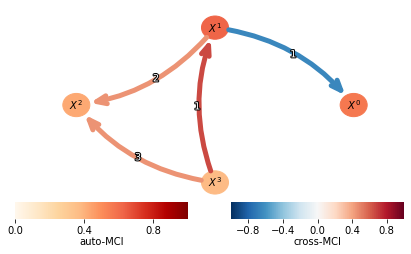

In [9]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

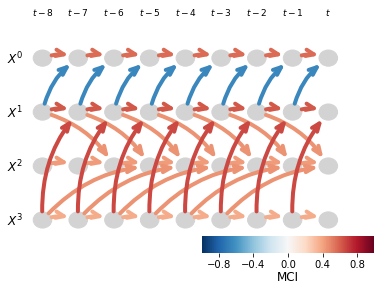

In [10]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off. You can adjust the size and aspect ratio of nodes with `node_size` and `node_aspect` parameters, and also modify many other properties, see the parameters of `plot_graph` and `plot_time_series_graph`.

## 3. Nonlinear conditional independence tests

If nonlinear dependencies are present, it is advisable to use a nonparametric test. Consider the following model:

\begin{align*}
    X^0_t &= 0.2 (X^1_{t-1})^2 + \eta^0_t\\
    X^1_t &= \eta^1_t \\
    X^2_t &= 0.3 (X^1_{t-2})^2 + \eta^2_t
\end{align*}

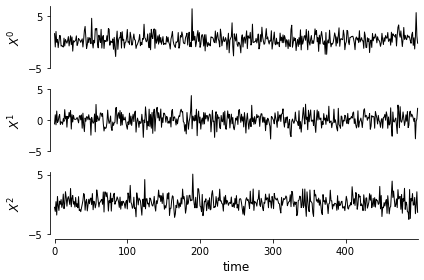

In [11]:
np.random.seed(1)
data = np.random.randn(500, 3)
for t in range(1, 500):
    data[t, 0] += 0.4*data[t-1, 1]**2
    data[t, 2] += 0.3*data[t-2, 1]**2
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe); plt.show()

In [12]:
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2, alpha_level = 0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 1 link(s):
        ($X^0$ -2): max_pval = 0.10814, min_val = -0.072

    Variable $X^1$ has 2 link(s):
        ($X^0$ -1): max_pval = 0.08389, min_val =  0.078
        ($X^1$ -1): max_pval = 0.19371, min_val = -0.059

    Variable $X^2$ has 1 link(s):
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.234

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 2
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.01:

    Variable $X^0$ has 0 link(s):

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 1 link(s):
        ($X^0$ -1): pval = 0.00000 | val =  0.234


``ParCorr`` here fails in two ways: (1) It cannot detect the two nonlinear links, (2) it wrongly detects a link $X^0_{t-1} \to X^2_t$ because it also cannot *condition out* a nonlinear dependency.

### GPDC

Tigramite covers nonlinear additive dependencies with a test based on *Gaussian process* regression and a *distance correlation* (``GPDC``) on the residuals. For GPDC no analytical null distribution of the distance correlation (DC) is available. For significance testing, Tigramite with the parameter ``significance = 'analytic'`` pre-computes the distribution for each sample size (stored in memory), thereby avoiding computationally expensive permutation tests for each conditional independence test (``significance = 'shuffle_test'``). GP regression is performed with ``sklearn`` default parameters, except for the *kernel* which here defaults to the radial basis function + a white kernel (both hyperparameters are internally optimized) and the assumed noise level ``alpha`` which is set to zero since we added a white kernel. These and other parameters can be set via the ``gp_params`` dictionary. See the documentation in ``sklearn`` for further discussion. There also exists a module (``gpdc_torch.py``) which exploits ``gpytorch`` for faster computations on GPUs.

In [13]:
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
    verbosity=0)

In contrast to ParCorr, the nonlinear links are correctly detected with GPDC:

In [ ]:
results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=0.1, alpha_level = 0.01)

As a short excursion, we can see how GPDC works looking at the scatter plots:

In [ ]:
array, dymmy, dummy = gpdc._get_array(X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)
x, meanx = gpdc._get_single_residuals(array, target_var=0, return_means=True)
y, meany = gpdc._get_single_residuals(array, target_var=1, return_means=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
axes[0].scatter(array[2], array[0], color='grey')
axes[0].scatter(array[2], meanx, color='black')
axes[0].set_title("GP of %s on %s" % (var_names[0], var_names[1]) )
axes[0].set_xlabel(var_names[1]); axes[0].set_ylabel(var_names[0])
axes[1].scatter(array[2], array[1], color='grey')
axes[1].scatter(array[2], meany, color='black')
axes[1].set_title("GP of %s on %s" % (var_names[2], var_names[1]) )
axes[1].set_xlabel(var_names[1]); axes[1].set_ylabel(var_names[2])
axes[2].scatter(x, y, color='red')
axes[2].set_title("DC of residuals:" "\n val=%.3f / p-val=%.3f" % (gpdc.run_test(
            X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)) )
axes[2].set_xlabel("resid. "+var_names[0]); axes[2].set_ylabel("resid. "+var_names[2])
plt.tight_layout()

Let's look at some even more nonlinear dependencies in a model with multiplicative noise:

In [ ]:
np.random.seed(42)
data = np.random.randn(500, 3)
for t in range(1, 500):
    data[t, 0] *= 0.2*data[t-1, 1]
    data[t, 2] *= 0.3*data[t-2, 1]
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe); plt.show()

Since multiplicative noise violates the assumption of additive dependencies underlying GPDC, the spurious link  $X^0_{t-1} \to X^2_t$ is wrongly detected because it cannot be *conditioned out*. In contrast to ParCorr, however, the two true links *are* detected because DC detects any kind of dependency:

In [ ]:
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc)
results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=0.1, alpha_level = 0.01)

Here we can see in the scatter plot, that the Gaussian Process cannot fit the dependencies and the residuals are, thus, not independent.

In [ ]:
array, dymmy, dummy = gpdc._get_array(X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)
x, meanx = gpdc._get_single_residuals(array, target_var=0, return_means=True)
y, meany = gpdc._get_single_residuals(array, target_var=1, return_means=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
axes[0].scatter(array[2], array[0], color='grey')
axes[0].scatter(array[2], meanx, color='black')
axes[0].set_title("GP of %s on %s" % (var_names[0], var_names[1]) )
axes[0].set_xlabel(var_names[1]); axes[0].set_ylabel(var_names[0])
axes[1].scatter(array[2], array[1], color='grey')
axes[1].scatter(array[2], meany, color='black')
axes[1].set_title("GP of %s on %s" % (var_names[2], var_names[1]) )
axes[1].set_xlabel(var_names[1]); axes[1].set_ylabel(var_names[2])
axes[2].scatter(x, y, color='red', alpha=0.3)
axes[2].set_title("DC of residuals:" "\n val=%.3f / p-val=%.3f" % (gpdc.run_test(
            X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)) )
axes[2].set_xlabel("resid. "+var_names[0]); axes[2].set_ylabel("resid. "+var_names[2])
plt.tight_layout()

### CMIknn

The most general conditional independence test implemented in Tigramite is CMIknn based on conditional mutual information estimated with a k-nearest neighbor estimator. This test is described in the paper 

Runge, Jakob. 2018. “Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information.” In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics. 

CMIknn involves no assumptions about the dependencies. The parameter ``knn`` determines the size of hypercubes, ie., the (data-adaptive) local length-scale. Now we cannot even pre-compute the null distribution because CMIknn is not residual-based like GPDC and the null distribution depends on many more factors. We, therefore, use ``significance='shuffle_test'`` to generate it in each individual test. The shuffle test for testing $I(X;Y|Z)=0$ shuffles $X$ values *locally*: Each sample point $i$’s $x$-value is mapped randomly
to one of its nearest neigbors (``shuffle_neighbors`` parameter) in subspace $Z$. Another free parameter is ``transform`` which specifies whether data is transformed before CMI estimation. The new default is ``transform=ranks`` which works better than the old ``transform=standardize``.
The following cell may take some minutes.

In [ ]:
cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks')
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=2)
results = pcmci_cmi_knn.run_pcmci(tau_max=2, pc_alpha=0.05, alpha_level = 0.01)

In [ ]:
## Significant links at alpha = 0.01:

#     Variable $X^0$ has 1 link(s):
#         ($X^1$ -1): pval = 0.00000 | val = 0.284

#     Variable $X^1$ has 0 link(s):

#     Variable $X^2$ has 1 link(s):
#         ($X^1$ -2): pval = 0.00000 | val = 0.242

In [ ]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmin_edges=0.,
    vmax_edges = 0.3,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.5,
    node_ticks=.1,
    cmap_nodes='OrRd',
    ); plt.show()

Here CMIknn correctly detects the true links and also unveils the spurious link. While CMIknn may now seem as the best independence test choice, we have to note that the generality comes at the cost of much lower power for the case that the dependencies actually follow some parametric form. Then ParCorr or GPDC are much more powerful measures. Of course, ParCorr also detects linear links better than GPDC. 

## 4. Symbolic time series

Symbolic (or discrete) data may arise naturally or continuously-valued time series can be converted to symbolic data. To accommodate such time series, Tigramite includes the ``CMIsymb`` conditional independence test based on conditional mutual information estimated directly from the histogram of discrete values. Usually a (quantile-)binning  applied to continuous data in order to use a discrete CMI estimator is not recommended (rather use ``CMIknn``), but here we do it anyway to get some symbolic data. We again consider the nonlinear time series example and convert to a symbolic series with 4 bins.

In [ ]:
np.random.seed(1)
data = np.random.randn(2000, 3)
for t in range(1, 2000):
    data[t, 0] += 0.4*data[t-1, 1]**2
    data[t, 2] += 0.3*data[t-2, 1]**2
data = pp.quantile_bin_array(data, bins=4)
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe, figsize=(10,4)); plt.show()

CMIsymb is initialized with ``n_symbs=None`` implying that the number of symbols is determined as ``n_symbs=data.max()+1``. Again, we have to use a shuffle test. Symbolic CMI works not very well here, only for 2000 samples was the correct graph reliably detected.

In [ ]:
# cmi_symb = CMIsymb(significance='shuffle_test', n_symbs=None)
# pcmci_cmi_symb = PCMCI(
#     dataframe=dataframe, 
#     cond_ind_test=cmi_symb)
# results = pcmci_cmi_symb.run_pcmci(tau_max=2, pc_alpha=0.2, alpha_level = 0.01)

In [ ]:
## Significant links at alpha = 0.01:

#     Variable $X^0$ has 1 link(s):
#         ($X^1$ -1): pval = 0.00000 | val = 0.040

#     Variable $X^1$ has 0 link(s):

#     Variable $X^2$ has 1 link(s):
#         ($X^1$ -2): pval = 0.00000 | val = 0.065